In [1]:
import sys
import pickle
import os
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])
import numpy as np

sys.path.append('../diffusion-models-for-cosmological-fields/annotated/')
sys.path.append('../diffusion-models-for-cosmological-fields/annotated/classifier_scripts/')
import classifier_architecture as cmodels_time
import utils
import evaluate
import hf_diffusion as hfd

/n/home02/nmudur/.conda/envs/rocky4/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
if torch.cuda.is_available():
    device='cuda'
else:
    device= 'cpu'
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float32)

In [3]:
p = evaluate.get_validation_cosmo_params(Bsize=5, seed=9, replace=False)
p

array([[0.3582 , 0.627  , 3.15579, 0.74432, 1.17202, 0.6246 ],
       [0.1786 , 0.9494 , 0.31425, 0.53663, 0.8322 , 1.88035],
       [0.231  , 0.8082 , 0.30993, 0.70613, 0.69786, 1.25093],
       [0.4074 , 0.799  , 2.74727, 0.83162, 1.63921, 1.09505],
       [0.2558 , 0.7538 , 0.48431, 0.75471, 0.8162 , 0.57554]],
      dtype=float32)

In [4]:
fields_dir = '/n/holylfs05/LABS/finkbeiner_lab/Everyone/CAMELS/CMD2D/data/'

In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [6]:
annotdir = '../diffusion-models-for-cosmological-fields/annotated/'

In [7]:
from matplotlib.ticker import FormatStrFormatter

In [8]:
plt.rcParams.update({'font.size': 16})

### Plot: Comparison figures

In [9]:
basedir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/'

In [10]:
rdir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/'

In [11]:
def get_hmc_dir_mapping(idx_noise, idx_field):
    nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
    if idx_noise==0 and idx_field==8:
        return os.path.join(basedir, 'param_set2_0')
    elif idx_noise==0:
        return os.path.join(basedir, f'param_{idx_field}')
    else:
        nname = nmap[idx_noise]
        return os.path.join(rdir, f'Std_{nname}_field-{idx_field}')


In [12]:
infnetresults = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [13]:
infnetresults.keys(), len(infnetresults['results_paraminf'])

(dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf']),
 4)

In [14]:
IFIELDS = [0,1,2,5,8]
BURN = 100
fcol = '#085c64'

In [15]:
nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
nlabels=['$x_0$', '$x_0 + 0.01\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', '$x_0 + 0.02\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', f'$x_0 + 0.05\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$']

In [16]:
nlabels

['$x_0$',
 '$x_0 + 0.01\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.02\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.05\\epsilon, \\epsilon\\sim\\mathcal{N}(0, 1)$']

In [17]:
fdict = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [18]:
fdict.keys()

dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf'])

In [19]:
fdict['models'] # is noise levels

['True Fields', 'Std_0.01', 'Std_0.02', 'Std_0.05']

In [20]:
len(fdict['samples'])

4

In [21]:
fdict['samples'][0].shape

(10, 1, 256, 256)

In [22]:
EG_ID = 2

In [23]:
INOISES = [0, 1, 2]
# Generate dummy image data
images = [fdict['samples'][inoise][EG_ID, 0] for inoise in INOISES]  # Placeholder for your actual image data
# Generate Pk
k2pk = False
percentiles = True
select_k = True
logscale = True
put_wavenumber_on_x = True

kvals, pklist = evaluate.get_powspec_for_samples([10**np.expand_dims(img, axis=0) for img in images], normalize=True)
k_idx = np.unique(np.arange(len(kvals))[np.logspace(0, np.log10(len(kvals)), 50).astype(int)])


In [24]:
import matplotlib.gridspec as gridspec

In [25]:
pklist[0].shape

(1, 128)

In [26]:
import matplotlib

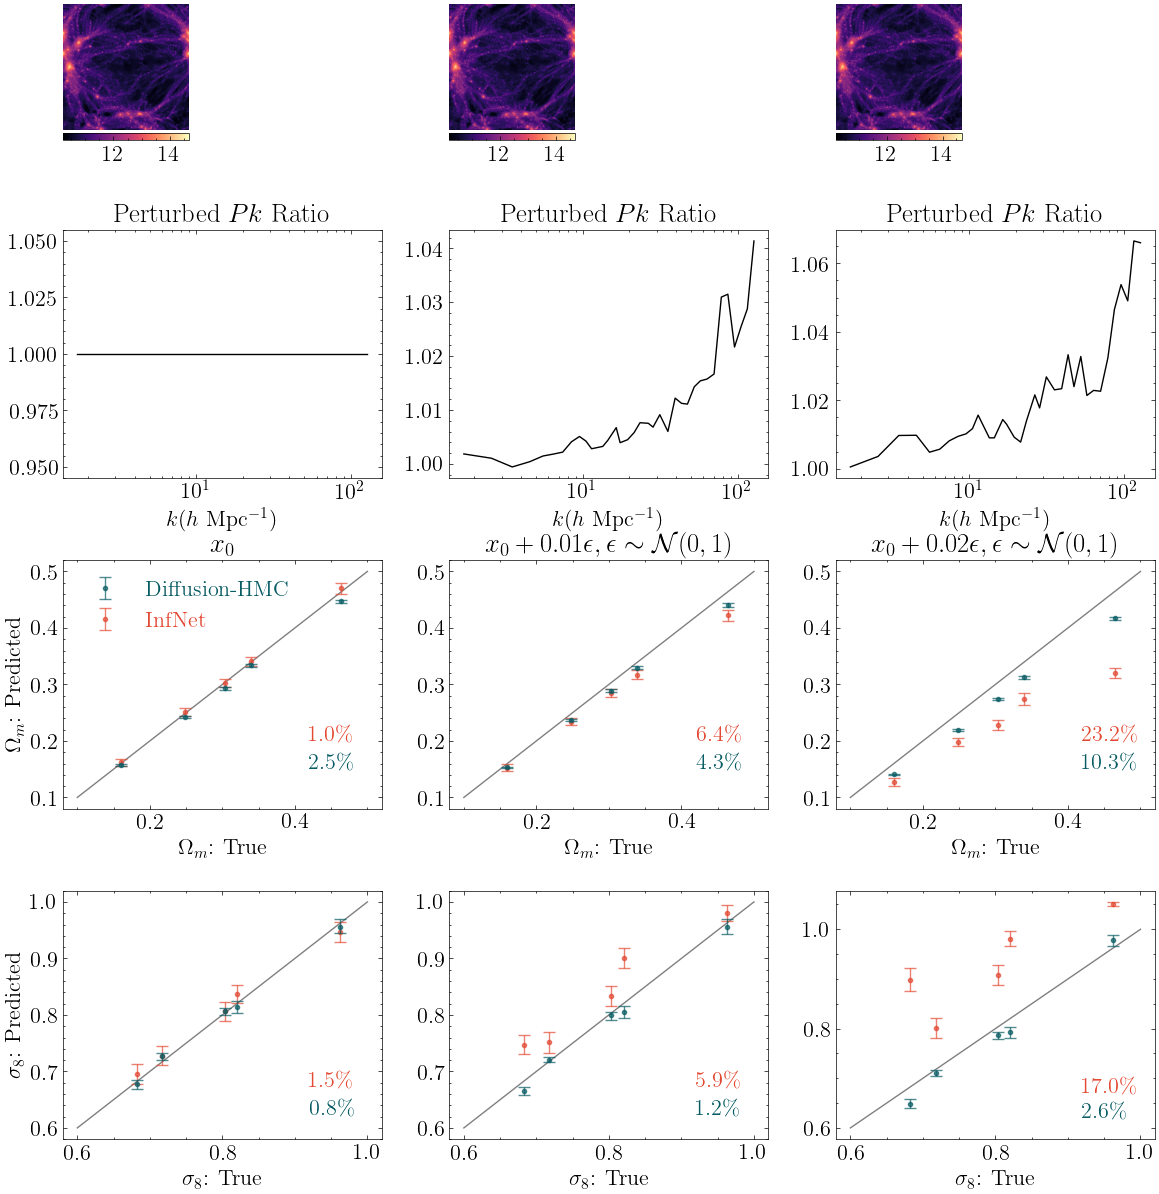

In [27]:
# Create the figure with a specific GridSpec layout
fig = plt.figure(figsize=(12, 14))
gs = matplotlib.gridspec.GridSpec(4, 6, height_ratios=[1, .8, .8, .8], width_ratios=[1]*6, hspace=0.3, wspace=0.8)

# Adding smaller axes at the top for images in the same row
ax_image1 = [fig.add_subplot(gs[0, 2*i]) for i in range(3)]
# ax_image1 = [fig.add_subplot(gs[0, 2*i]) for i in range(3)]
ax_image2 = [fig.add_subplot(gs[1, 2*i:2*i+2]) for i in range(3)]


for i in INOISES:
    # Display images in the first row
    ax_image1[i].set_position([0.5 + i * 0.3, 0.75, 0.2, 0.2])  # Adjust the values as needed
    im1 = ax_image1[i].imshow(images[i], cmap='magma')
    ax_image1[i].axis('off')  # Turn off axis
    plt.colorbar(im1, ax=ax_image1[i], orientation='horizontal', fraction=0.046, pad=0.01)
    ax_image2[i].plot(kvals[k_idx], pklist[i][0, k_idx]/pklist[0][0, k_idx], c='k') #ratio of noisy pk/ pk original
    ax_image2[i].set_xscale('log')
    ax_image2[i].set_title(f'Perturbed $Pk$ Ratio')
    ax_image2[i].set_xlabel(r'$k (h$ Mpc$^{-1}$)')

# Create axes for the plots below using the remaining rows in GridSpec
for inoise in INOISES:
    om_gt, om_pred, om_pcts = [], [], []
    sig8_gt, sig8_pred, sig8_pcts = [], [], []

    for ifield in IFIELDS:
        pdir = get_hmc_dir_mapping(inoise, ifield)
        config = pickle.load(open(pdir+'/config.pkl', 'rb'))
        psamps = np.load(pdir+'/samps.npy')
        psubset = psamps[BURN:]
        
        om_gt.append(config['trueparam'].flatten()[0])
        sig8_gt.append(config['trueparam'].flatten()[1])
        om_pred.append(psubset[:, 0].mean())
        sig8_pred.append(psubset[:, 1].mean())
        
        om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
        sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

    om_pcts = np.vstack(om_pcts)
    sig8_pcts = np.vstack(sig8_pcts)
    om_pred = np.array(om_pred)
    sig8_pred = np.array(sig8_pred)
    om_bias_gt = np.mean(np.abs((om_pred - om_gt)/om_gt))*100
    sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt)/sig8_gt))*100

    # get param inf net predictions
    om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
    om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
    om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
    sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
    sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
    sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
    om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in)/om_gt_in))*100
    sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in)/sig8_gt_in))*100

    ax = fig.add_subplot(gs[2, 2*inoise:2*inoise+2])    
    ax.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
    ax.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1]- om_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
    ax.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
    ax.set_xlabel(r'$\Omega_m$: True')
    ax.annotate(f'{om_bias_gt:.1f}\%',xy=(0.42, 0.15), color=fcol) # xy=(0.05, 0.95),
    ax.annotate(f'{om_bias_gt_in:.1f}\%',xy=(0.42, 0.2),color='#e34a33')
    ax.set_title(nlabels[inoise])
    if inoise==0:
        ax.set_ylabel(r'$\Omega_m$: Predicted')
    if inoise==0:
        ax.legend(loc='upper left')
        leg = ax.get_legend()
        tcols = [fcol, '#e34a33']
        for i, text in enumerate(leg.get_texts()):
            text.set_color(tcols[i])

    ax = fig.add_subplot(gs[3, 2*inoise:2*inoise+2])
    ax.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
    ax.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1]- sig8_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='DM Prediction', zorder=10, alpha=0.7)
    ax.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet Prediction', alpha=0.7)
    ax.set_xlabel(r'$\sigma_8$: True')
    ax.annotate(f'{sig8_bias_gt:.1f}\%', xy=(0.92, 0.65), ha='left', va='top', color=fcol) # ,
    ax.annotate(f'{sig8_bias_gt_in:.1f}\%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

    if inoise==0:
        ax.set_ylabel(r'$\sigma_8$: Predicted')
gs.tight_layout(fig, h_pad=0)
plt.savefig('Figures/Final/noise_robustness_2panel_clean.pdf')
plt.show()

### Plot: Comparison WITHOUT PRIOR for all three

In [9]:
basedir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/'

In [10]:
rdir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/'

In [11]:
def get_hmc_dir_mapping(idx_noise, idx_field):
    nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
    if idx_noise==0 and idx_field==8:
        return os.path.join(basedir, 'param_set2_0')
    elif idx_noise==0:
        return os.path.join(basedir, f'param_{idx_field}')
    else:
        nname = nmap[idx_noise]
        return os.path.join(rdir, f'noprior_Std_{nname}_field-{idx_field}')


In [12]:
infnetresults = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [13]:
infnetresults.keys(), len(infnetresults['results_paraminf'])

(dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf']),
 4)

In [14]:
IFIELDS = [0,1,2,5,8]
BURN = 100
fcol = '#085c64'

In [15]:
nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
nlabels=['$x_0$', '$x_0 + 0.01\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', '$x_0 + 0.02\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', f'$x_0 + 0.05\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$']

In [16]:
nlabels

['$x_0$',
 '$x_0 + 0.01\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.02\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.05\\epsilon, \\epsilon\\sim\\mathcal{N}(0, 1)$']

In [17]:
fdict = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [18]:
fdict.keys()

dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf'])

In [19]:
fdict['models'] # is noise levels

['True Fields', 'Std_0.01', 'Std_0.02', 'Std_0.05']

In [20]:
len(fdict['samples'])

4

In [21]:
fdict['samples'][0].shape

(10, 1, 256, 256)

In [22]:
EG_ID=2

In [23]:
EG_ID = 2

In [24]:
INOISES = [0, 1, 2, 3]
# Generate dummy image data
images = [fdict['samples'][inoise][EG_ID, 0] for inoise in INOISES]  # Placeholder for your actual image data
# Generate Pk
k2pk = False
percentiles = True
select_k = True
logscale = True
put_wavenumber_on_x = True

kvals, pklist = evaluate.get_powspec_for_samples([10**np.expand_dims(img, axis=0) for img in images], normalize=True)
k_idx = np.unique(np.arange(len(kvals))[np.logspace(0, np.log10(len(kvals)), 50).astype(int)])


In [25]:
import matplotlib.gridspec as gridspec

In [26]:
pklist[0].shape

(1, 128)

In [27]:
infnetresults['results_paraminf'][0][0][EG_ID, 0], infnetresults['results_paraminf'][0][0][EG_ID, 1]

(0.3394, 0.9626)

In [28]:
import matplotlib

In [29]:
INOISES

[0, 1, 2, 3]

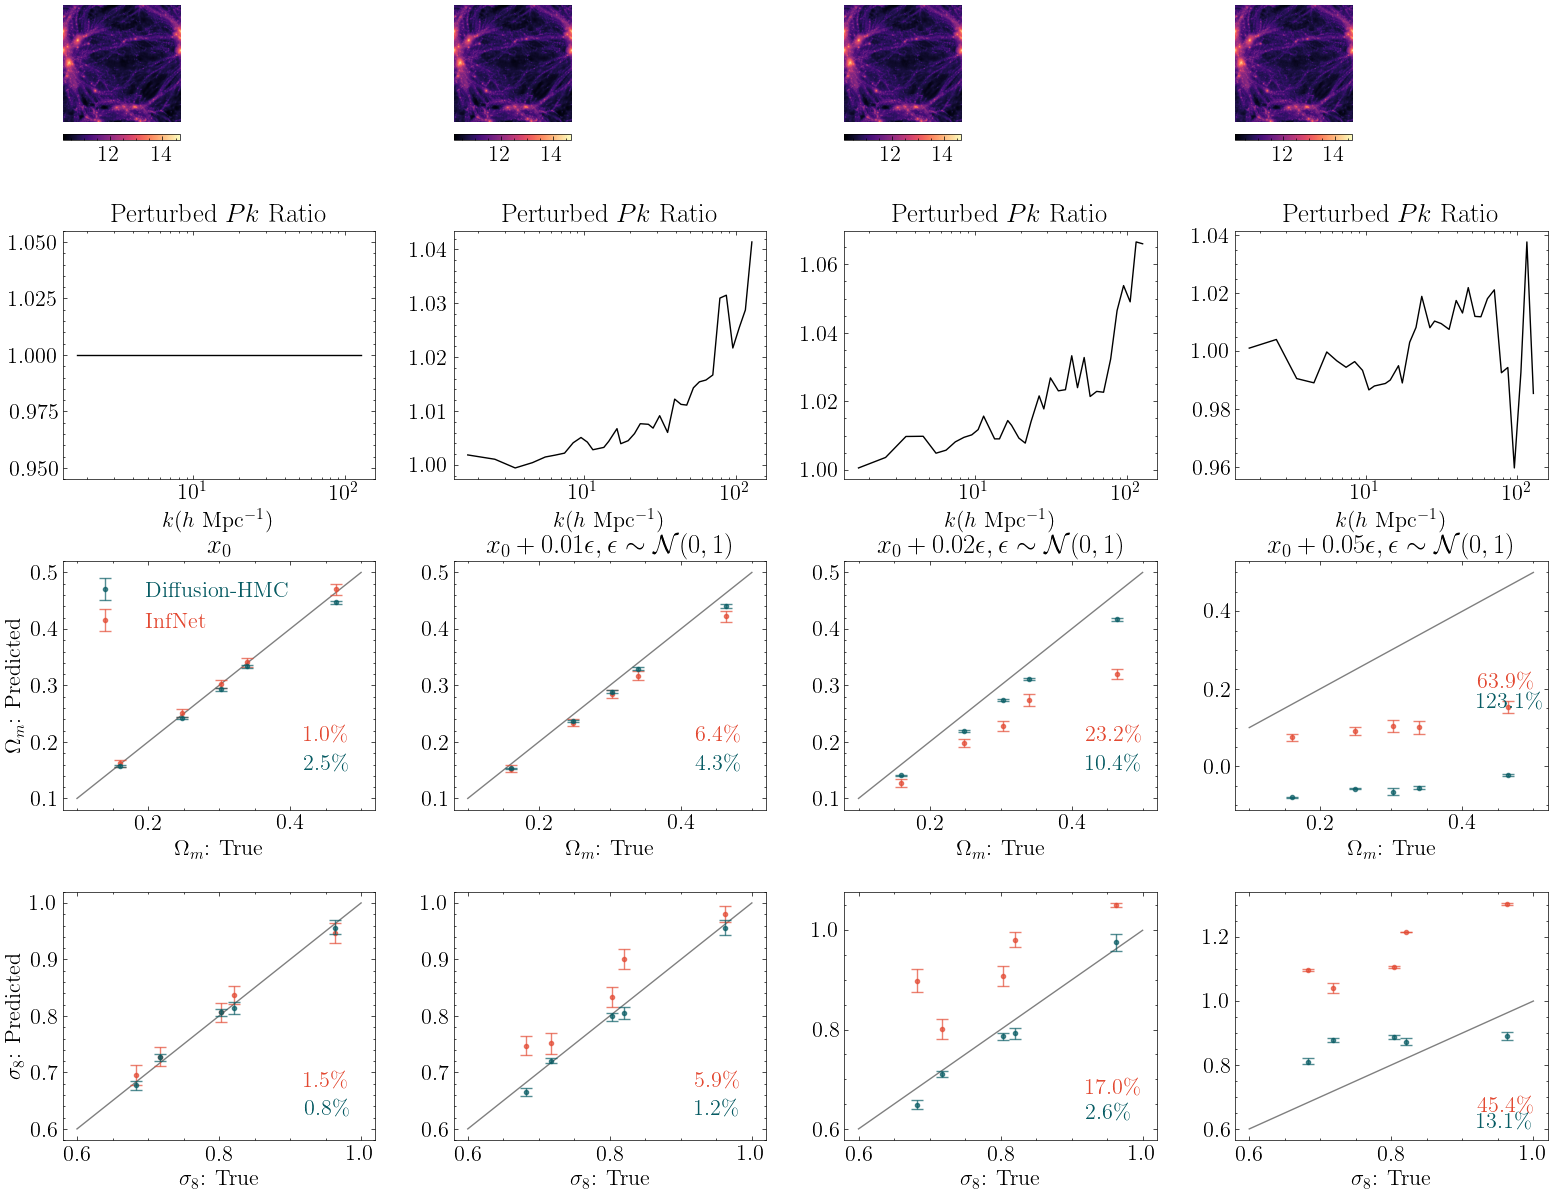

In [30]:
# Create the figure with a specific GridSpec layout
fig = plt.figure(figsize=(16, 14))
gs = matplotlib.gridspec.GridSpec(4, 8, height_ratios=[1, .8, .8, .8], width_ratios=[1]*8, hspace=0.3, wspace=0.8)

# Adding smaller axes at the top for images in the same row
ax_image1 = [fig.add_subplot(gs[0, 2*i]) for i in range(len(INOISES))]
# ax_image1 = [fig.add_subplot(gs[0, 2*i]) for i in range(3)]
ax_image2 = [fig.add_subplot(gs[1, 2*i:2*i+2]) for i in range(len(INOISES))]

"""
fig = plt.figure(figsize=(15, 12))
gs = matplotlib.gridspec.GridSpec(3, 8, height_ratios=[1]*3, width_ratios=[1]*8, hspace=0.4, wspace=0.8)
"""

for i in INOISES:
    # Display images in the first row
    ax_image1[i].set_position([0.5 + i * 0.3, 0.75, 0.2, 0.2])  # Adjust the values as needed
    im1 = ax_image1[i].imshow(images[i], cmap='magma')
    ax_image1[i].axis('off')  # Turn off axis
    plt.colorbar(im1, ax=ax_image1[i], orientation='horizontal', fraction=0.046, pad=0.04)
    ax_image2[i].plot(kvals[k_idx], pklist[i][0, k_idx]/pklist[0][0, k_idx], c='k') #ratio of noisy pk/ pk original
    ax_image2[i].set_xscale('log')
    ax_image2[i].set_title(f'Perturbed $Pk$ Ratio')
    ax_image2[i].set_xlabel(r'$k (h$ Mpc$^{-1}$)')

# Create axes for the plots below using the remaining rows in GridSpec
for inoise in INOISES:
    om_gt, om_pred, om_pcts = [], [], []
    sig8_gt, sig8_pred, sig8_pcts = [], [], []

    for ifield in IFIELDS:
        pdir = get_hmc_dir_mapping(inoise, ifield)
        config = pickle.load(open(pdir+'/config.pkl', 'rb'))
        psamps = np.load(pdir+'/samps.npy')
        psubset = psamps[BURN:]
        
        om_gt.append(config['trueparam'].flatten()[0])
        sig8_gt.append(config['trueparam'].flatten()[1])
        om_pred.append(psubset[:, 0].mean())
        sig8_pred.append(psubset[:, 1].mean())
        
        om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
        sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

    om_pcts = np.vstack(om_pcts)
    sig8_pcts = np.vstack(sig8_pcts)
    om_pred = np.array(om_pred)
    sig8_pred = np.array(sig8_pred)
    om_bias_gt = np.mean(np.abs((om_pred - om_gt)/om_gt))*100
    sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt)/sig8_gt))*100

    # get param inf net predictions
    om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
    om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
    om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
    sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
    sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
    sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
    om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in)/om_gt_in))*100
    sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in)/sig8_gt_in))*100

    ax = fig.add_subplot(gs[2, 2*inoise:2*inoise+2])    
    ax.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
    ax.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1]- om_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
    ax.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
    ax.set_xlabel(r'$\Omega_m$: True')
    ax.annotate(f'{om_bias_gt:.1f}\%',xy=(0.42, 0.15), color=fcol) # xy=(0.05, 0.95),
    ax.annotate(f'{om_bias_gt_in:.1f}\%',xy=(0.42, 0.2),color='#e34a33')
    ax.set_title(nlabels[inoise])
    if inoise==0:
        ax.set_ylabel(r'$\Omega_m$: Predicted')
    if inoise==0:
        ax.legend(loc='upper left')
        leg = ax.get_legend()
        tcols = [fcol, '#e34a33']
        for i, text in enumerate(leg.get_texts()):
            text.set_color(tcols[i])

    ax = fig.add_subplot(gs[3, 2*inoise:2*inoise+2])
    ax.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
    ax.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1]- sig8_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='DM Prediction', zorder=10, alpha=0.7)
    ax.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet Prediction', alpha=0.7)
    ax.set_xlabel(r'$\sigma_8$: True')
    ax.annotate(f'{sig8_bias_gt:.1f}\%', xy=(0.92, 0.65), ha='left', va='top', color=fcol) # ,
    ax.annotate(f'{sig8_bias_gt_in:.1f}\%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

    if inoise==0:
        ax.set_ylabel(r'$\sigma_8$: Predicted')
gs.tight_layout(fig, h_pad=0)
plt.savefig('Figures/Final/noise_robustness_2panel_weg_noprior_clean.pdf')
plt.show()

### Drop the first 2 timesteps: range(2, 20)

In [9]:
basedir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/'

In [10]:
rdir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/'

In [11]:
os.listdir(rdir)

['Std_0.01_field-2',
 'noprior_Std_0.02_field-1',
 'Std_0.05_field-0',
 'noprior_Std_0.02_field-5',
 'noprior_Std_0.05_field-0',
 'noprior_Std_0.01_field-2',
 'noprior_Std_0.05_field-5',
 'Std_0.02_field-1',
 'Std_0.01_field-0',
 'Std_0.02_field-5',
 'Std_0.05_field-5',
 'noprior_Std_0.01_field-0',
 'Std_0.01_test_field-2',
 'dropt_noprior_Std_0.05_field-0',
 'Std_0.02_field-0',
 'noprior_Std_0.01_field-5',
 'noprior_Std_0.02_field-2',
 'Std_0.02_field-8',
 'noprior_Std_0.02_field-8',
 'dropt_noprior_Std_0.05_field-5',
 'noprior_Std_0.02_field-0',
 'Std_0.01_field-5',
 'dropt_noprior_Std_0.05_field-8',
 'Std_0.02_field-2',
 'dropt_noprior_Std_0.02_field-5',
 'noprior_Std_0.05_field-8',
 'noprior_Std_0.05_field-1',
 'dropt_noprior_Std_0.05_field-1',
 'dropt_noprior_Std_0.02_field-2',
 'dropt_noprior_Std_0.02_field-1',
 'noprior_Std_0.01_field-8',
 'Std_0.05_field-1',
 'Std_0.01_field-8',
 'dropt_noprior_Std_0.05_field-2',
 'dropt_noprior_Std_0.02_field-8',
 'Std_0.05_field-8',
 'noprior

In [12]:
def get_hmc_dir_mapping(idx_noise, idx_field):
    nmap = {2: '0.02', 3: '0.05'}
    if idx_noise==0 and idx_field==8:
        return os.path.join(basedir, 'param_set2_0')
    elif idx_noise==0:
        return os.path.join(basedir, f'param_{idx_field}')
    else:
        nname = nmap[idx_noise]
        return os.path.join(rdir, f'dropt_noprior_Std_{nname}_field-{idx_field}')


In [13]:
IFIELDS = [0,1,2,5,8]

In [14]:
BURN = 100
import matplotlib

In [15]:
infnetresults = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [16]:
infnetresults.keys(), len(infnetresults['results_paraminf'])

(dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf']),
 4)

In [17]:
fcol = '#085c64'
nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
nlabels=['$x_0$', '$x_0 + 0.01\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', '$x_0 + 0.02\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', f'$x_0 + 0.05\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$']

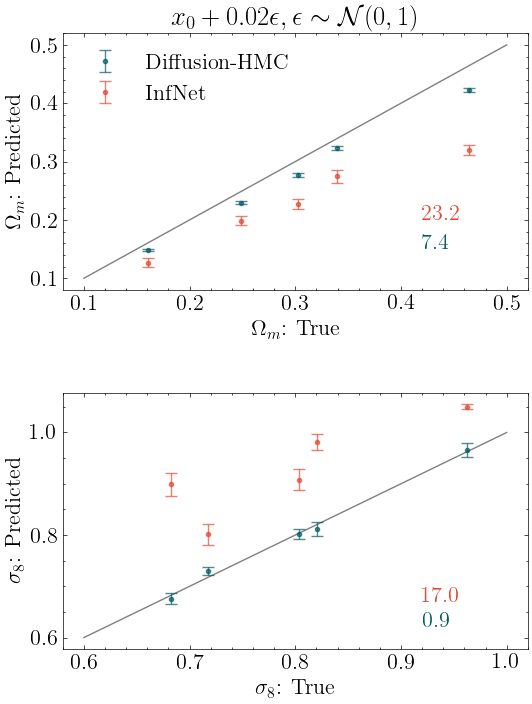

In [29]:
# Create the figure with 2 rows and 1 column layout
fig = plt.figure(figsize=(6, 8))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)

# Set the specific noise level you want to analyze (replace `inoise` with the desired value)
inoise = 2  # Adjust this to select a specific noise level

# Create axes for the two plots below using the GridSpec layout
om_gt, om_pred, om_pcts = [], [], []
sig8_gt, sig8_pred, sig8_pcts = [], [], []

for ifield in IFIELDS:
    pdir = get_hmc_dir_mapping(inoise, ifield)
    config = pickle.load(open(pdir + '/config.pkl', 'rb'))
    psamps = np.load(pdir + '/samps.npy')
    psubset = psamps[BURN:]

    om_gt.append(config['trueparam'].flatten()[0])
    sig8_gt.append(config['trueparam'].flatten()[1])
    om_pred.append(psubset[:, 0].mean())
    sig8_pred.append(psubset[:, 1].mean())

    om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
    sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

om_pcts = np.vstack(om_pcts)
sig8_pcts = np.vstack(sig8_pcts)
om_pred = np.array(om_pred)
sig8_pred = np.array(sig8_pred)
om_bias_gt = np.mean(np.abs((om_pred - om_gt) / om_gt)) * 100
sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt) / sig8_gt)) * 100

# Get param inf net predictions
om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in) / om_gt_in)) * 100
sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in) / sig8_gt_in)) * 100

# First plot: Omega_m (Ωm)
ax1 = fig.add_subplot(gs[0])
ax1.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
ax1.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1] - om_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
ax1.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
ax1.set_xlabel(r'$\Omega_m$: True')
ax1.set_ylabel(r'$\Omega_m$: Predicted')
ax1.annotate(f'{om_bias_gt:.1f}%', xy=(0.42, 0.15), color=fcol)
ax1.annotate(f'{om_bias_gt_in:.1f}%', xy=(0.42, 0.2), color='#e34a33')
ax1.set_title(nlabels[inoise])
ax1.legend(loc='upper left')

# Second plot: Sigma_8 (σ8)
ax2 = fig.add_subplot(gs[1])
ax2.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
ax2.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1] - sig8_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, zorder=10, alpha=0.7)
ax2.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, alpha=0.7)
ax2.set_xlabel(r'$\sigma_8$: True')
ax2.set_ylabel(r'$\sigma_8$: Predicted')
ax2.annotate(f'{sig8_bias_gt:.1f}%', xy=(0.92, 0.65), ha='left', va='top', color=fcol)
ax2.annotate(f'{sig8_bias_gt_in:.1f}%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

plt.savefig('Figures/Final/noise_robustness_dropt_0-02.pdf')
plt.show()


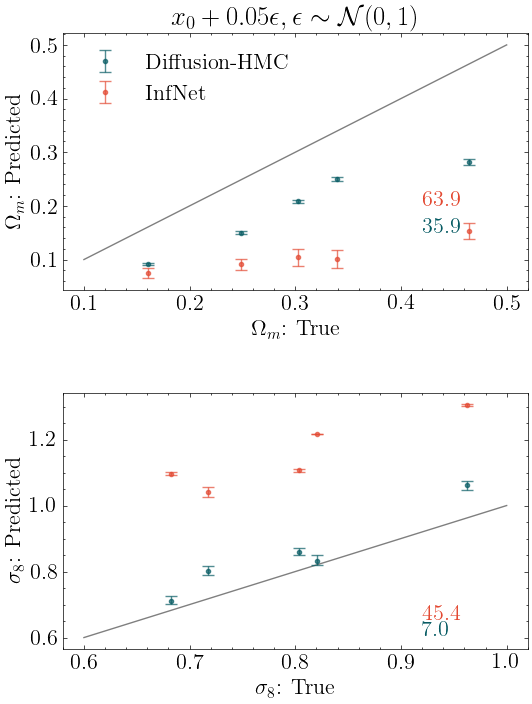

In [30]:
# Create the figure with 2 rows and 1 column layout
fig = plt.figure(figsize=(6, 8))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)

# Set the specific noise level you want to analyze (replace `inoise` with the desired value)
inoise = 3  # Adjust this to select a specific noise level

# Create axes for the two plots below using the GridSpec layout
om_gt, om_pred, om_pcts = [], [], []
sig8_gt, sig8_pred, sig8_pcts = [], [], []

for ifield in IFIELDS:
    pdir = get_hmc_dir_mapping(inoise, ifield)
    config = pickle.load(open(pdir + '/config.pkl', 'rb'))
    psamps = np.load(pdir + '/samps.npy')
    psubset = psamps[BURN:]

    om_gt.append(config['trueparam'].flatten()[0])
    sig8_gt.append(config['trueparam'].flatten()[1])
    om_pred.append(psubset[:, 0].mean())
    sig8_pred.append(psubset[:, 1].mean())

    om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
    sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

om_pcts = np.vstack(om_pcts)
sig8_pcts = np.vstack(sig8_pcts)
om_pred = np.array(om_pred)
sig8_pred = np.array(sig8_pred)
om_bias_gt = np.mean(np.abs((om_pred - om_gt) / om_gt)) * 100
sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt) / sig8_gt)) * 100

# Get param inf net predictions
om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in) / om_gt_in)) * 100
sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in) / sig8_gt_in)) * 100

# First plot: Omega_m (Ωm)
ax1 = fig.add_subplot(gs[0])
ax1.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
ax1.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1] - om_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
ax1.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
ax1.set_xlabel(r'$\Omega_m$: True')
ax1.set_ylabel(r'$\Omega_m$: Predicted')
ax1.annotate(f'{om_bias_gt:.1f}%', xy=(0.42, 0.15), color=fcol)
ax1.annotate(f'{om_bias_gt_in:.1f}%', xy=(0.42, 0.2), color='#e34a33')
ax1.set_title(nlabels[inoise])
ax1.legend(loc='upper left')

# Second plot: Sigma_8 (σ8)
ax2 = fig.add_subplot(gs[1])
ax2.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
ax2.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1] - sig8_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, zorder=10, alpha=0.7)
ax2.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, alpha=0.7)
ax2.set_xlabel(r'$\sigma_8$: True')
ax2.set_ylabel(r'$\sigma_8$: Predicted')
ax2.annotate(f'{sig8_bias_gt:.1f}%', xy=(0.92, 0.65), ha='left', va='top', color=fcol)
ax2.annotate(f'{sig8_bias_gt_in:.1f}%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

plt.savefig('Figures/Final/noise_robustness_dropt_0-05.pdf')
plt.show()

In [31]:
# Create the figure with 2 rows and 1 column layout
# This is a sanity check and should give you an error.
fig = plt.figure(figsize=(6, 8))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)

# Set the specific noise level you want to analyze (replace `inoise` with the desired value)
inoise = 1  # Adjust this to select a specific noise level

# Create axes for the two plots below using the GridSpec layout
om_gt, om_pred, om_pcts = [], [], []
sig8_gt, sig8_pred, sig8_pcts = [], [], []

for ifield in IFIELDS:
    pdir = get_hmc_dir_mapping(inoise, ifield)
    config = pickle.load(open(pdir + '/config.pkl', 'rb'))
    psamps = np.load(pdir + '/samps.npy')
    psubset = psamps[BURN:]

    om_gt.append(config['trueparam'].flatten()[0])
    sig8_gt.append(config['trueparam'].flatten()[1])
    om_pred.append(psubset[:, 0].mean())
    sig8_pred.append(psubset[:, 1].mean())

    om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
    sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

om_pcts = np.vstack(om_pcts)
sig8_pcts = np.vstack(sig8_pcts)
om_pred = np.array(om_pred)
sig8_pred = np.array(sig8_pred)
om_bias_gt = np.mean(np.abs((om_pred - om_gt) / om_gt)) * 100
sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt) / sig8_gt)) * 100

# Get param inf net predictions
om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in) / om_gt_in)) * 100
sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in) / sig8_gt_in)) * 100

# First plot: Omega_m (Ωm)
ax1 = fig.add_subplot(gs[0])
ax1.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
ax1.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1] - om_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
ax1.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
ax1.set_xlabel(r'$\Omega_m$: True')
ax1.set_ylabel(r'$\Omega_m$: Predicted')
ax1.annotate(f'{om_bias_gt:.1f}%', xy=(0.42, 0.15), color=fcol)
ax1.annotate(f'{om_bias_gt_in:.1f}%', xy=(0.42, 0.2), color='#e34a33')
ax1.set_title(nlabels[inoise])
ax1.legend(loc='upper left')

# Second plot: Sigma_8 (σ8)
ax2 = fig.add_subplot(gs[1])
ax2.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
ax2.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1] - sig8_pred, np.zeros(5))),
             fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, zorder=10, alpha=0.7)
ax2.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33',
             markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, alpha=0.7)
ax2.set_xlabel(r'$\sigma_8$: True')
ax2.set_ylabel(r'$\sigma_8$: Predicted')
ax2.annotate(f'{sig8_bias_gt:.1f}%', xy=(0.92, 0.65), ha='left', va='top', color=fcol)
ax2.annotate(f'{sig8_bias_gt_in:.1f}%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

plt.savefig('Figures/Final/noise_robustness_dropt_0-05.pdf')
plt.show()

KeyError: 1

<Figure size 600x800 with 0 Axes>

In [32]:
print(nmap[2])

0.02


In [33]:
print(get_hmc_dir_mapping(2, 3))

../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/dropt_noprior_Std_0.02_field-3


### Plot: Comparison figures

In [9]:
basedir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/'

In [10]:
rdir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/'

In [11]:
def get_hmc_dir_mapping(idx_noise, idx_field):
    nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
    if idx_noise==0 and idx_field==8:
        return os.path.join(basedir, 'param_set2_0')
    elif idx_noise==0:
        return os.path.join(basedir, f'param_{idx_field}')
    else:
        nname = nmap[idx_noise]
        return os.path.join(rdir, f'Std_{nname}_field-{idx_field}')


In [12]:
infnetresults = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [13]:
infnetresults.keys(), len(infnetresults['results_paraminf'])

(dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf']),
 4)

In [14]:
IFIELDS = [0,1,2,5,8]
BURN = 100
fcol = '#085c64'

In [15]:
nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
nlabels=['$x_0$', '$x_0 + 0.01\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', '$x_0 + 0.02\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', f'$x_0 + 0.05\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$']

In [16]:
nlabels

['$x_0$',
 '$x_0 + 0.01\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.02\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.05\\epsilon, \\epsilon\\sim\\mathcal{N}(0, 1)$']

In [17]:
fdict = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [18]:
fdict.keys()

dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf'])

In [19]:
fdict['models'] # is noise levels

['True Fields', 'Std_0.01', 'Std_0.02', 'Std_0.05']

In [20]:
len(fdict['samples'])

4

In [21]:
fdict['samples'][0].shape

(10, 1, 256, 256)

In [22]:
EG_ID = 2

In [23]:
INOISES = [0, 1, 2]
# Generate dummy image data
images = [fdict['samples'][inoise][EG_ID, 0] for inoise in INOISES]  # Placeholder for your actual image data
# Generate Pk
k2pk = False
percentiles = True
select_k = True
logscale = True
put_wavenumber_on_x = True

kvals, pklist = evaluate.get_powspec_for_samples([10**np.expand_dims(img, axis=0) for img in images], normalize=True)
k_idx = np.unique(np.arange(len(kvals))[np.logspace(0, np.log10(len(kvals)), 50).astype(int)])


In [24]:
import matplotlib.gridspec as gridspec

In [25]:
pklist[0].shape

(1, 128)

In [26]:
import matplotlib

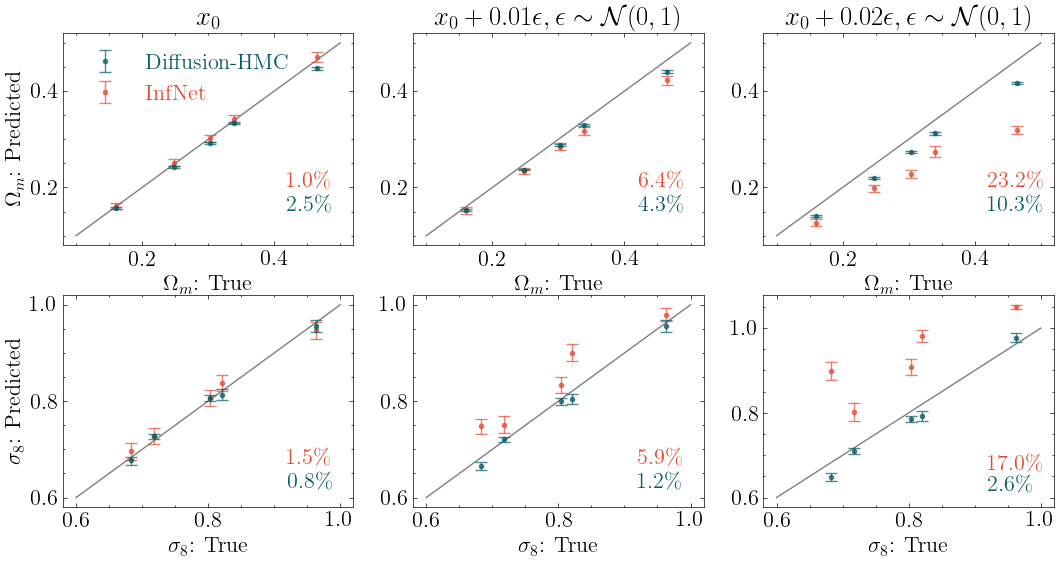

In [31]:
# Create the figure with a specific GridSpec layout
fig = plt.figure(figsize=(11, 6))
gs = matplotlib.gridspec.GridSpec(2, 6, height_ratios=[.8, .8], width_ratios=[1]*6, hspace=0.3, wspace=0.8)

# Create axes for the plots below using the remaining rows in GridSpec
for inoise in INOISES:
    om_gt, om_pred, om_pcts = [], [], []
    sig8_gt, sig8_pred, sig8_pcts = [], [], []

    for ifield in IFIELDS:
        pdir = get_hmc_dir_mapping(inoise, ifield)
        config = pickle.load(open(pdir+'/config.pkl', 'rb'))
        psamps = np.load(pdir+'/samps.npy')
        psubset = psamps[BURN:]
        
        om_gt.append(config['trueparam'].flatten()[0])
        sig8_gt.append(config['trueparam'].flatten()[1])
        om_pred.append(psubset[:, 0].mean())
        sig8_pred.append(psubset[:, 1].mean())
        
        om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
        sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

    om_pcts = np.vstack(om_pcts)
    sig8_pcts = np.vstack(sig8_pcts)
    om_pred = np.array(om_pred)
    sig8_pred = np.array(sig8_pred)
    om_bias_gt = np.mean(np.abs((om_pred - om_gt)/om_gt))*100
    sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt)/sig8_gt))*100

    # get param inf net predictions
    om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
    om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
    om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
    sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
    sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
    sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
    om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in)/om_gt_in))*100
    sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in)/sig8_gt_in))*100

    ax = fig.add_subplot(gs[0, 2*inoise:2*inoise+2])    
    ax.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
    ax.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1]- om_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
    ax.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
    ax.set_xlabel(r'$\Omega_m$: True')
    ax.annotate(f'{om_bias_gt:.1f}\%',xy=(0.42, 0.15), color=fcol) # xy=(0.05, 0.95),
    ax.annotate(f'{om_bias_gt_in:.1f}\%',xy=(0.42, 0.2),color='#e34a33')
    ax.set_title(nlabels[inoise])
    if inoise==0:
        ax.set_ylabel(r'$\Omega_m$: Predicted')
    if inoise==0:
        ax.legend(loc='upper left')
        leg = ax.get_legend()
        tcols = [fcol, '#e34a33']
        for i, text in enumerate(leg.get_texts()):
            text.set_color(tcols[i])

    ax = fig.add_subplot(gs[1, 2*inoise:2*inoise+2])
    ax.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
    ax.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1]- sig8_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='DM Prediction', zorder=10, alpha=0.7)
    ax.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet Prediction', alpha=0.7)
    ax.set_xlabel(r'$\sigma_8$: True')
    ax.annotate(f'{sig8_bias_gt:.1f}\%', xy=(0.92, 0.65), ha='left', va='top', color=fcol) # ,
    ax.annotate(f'{sig8_bias_gt_in:.1f}\%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

    if inoise==0:
        ax.set_ylabel(r'$\sigma_8$: Predicted')
gs.tight_layout(fig, h_pad=0)
plt.savefig('Figures/Final/noise_robustness_2rows.pdf')
plt.show()